In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_pickle('/kaggle/input/motley-fool-scraped-earnings-call-transcripts/motley-fool-data.pkl')

# Preprocessing

## Remove duplicates

In [3]:
data.shape

(18755, 5)

In [4]:
data=data.drop_duplicates(["transcript"])

In [5]:
data.shape

(17592, 5)

## check null

In [6]:
data=data.dropna()

## Spliting functions and change abberviations

In [7]:
def getSpeakers(data):
    if "Speakers" in data:
        return "\n".join([x for x in data.split("Speakers")[-1].split("\n") if "--" in x])
    elif "Call participants" in data:
        return "\n".join([x for x in data.split("Call participants")[-1].split("\n") if "--" in x])
    elif "Call Participants" in data:
        return "\n".join([x for x in data.split("Call Participants")[-1].split("\n") if "--" in x])
def removeSpeakers(data):
    if "Speakers" in data:
        return data.split("Speakers")[0]
    elif "Call participants" in data:
        return data.split("Call participants")[0]
    elif "Call Participants" in data:
        return data.split("Call Participants")[0]
def getQA(data):
    if "Questions and Answers" in data:    
        return data.split("Questions and Answers")[-1]
    elif  "Questions & Answers" in data:
        return data.split("Questions & Answers")[-1]
    elif "Q&A" in data:
        return data.split("Q&A")[-1]
    else:
        return ""
def removeQA(data):
    if "Questions and Answers" in data:    
        return data.split("Questions and Answers")[0]
    elif  "Questions & Answers" in data:
        return data.split("Questions & Answers")[0]
    elif "Q&A" in data:
        return data.split("Q&A")[0]
    else:
        return ""
def replace_abbreviations(text):
    
    replacements = {
        'Q1': 'first quarter',
        'Q2': 'second quarter',
        'Q3': 'third quarter',
        'Q4': 'fourth quarter',
        'q1': 'first quarter',
        'q2': 'second quarter',
        'q3': 'third quarter',
        'q4': 'fourth quarter',
        'FY': 'fiscal year',
        'YoY': 'year over year',
        'MoM': 'month over month',
        'EBITDA': 'earnings before interest, taxes, depreciation, and amortization',
        'ROI': 'return on investment',
        'EPS': 'earnings per share',
        'P/E': 'price-to-earnings',
        'DCF': 'discounted cash flow',
        'CAGR': 'compound annual growth rate',
        'GDP': 'gross domestic product',
        'CFO': 'chief financial officer',
        'GAAP': 'generally accepted accounting principles',
        'SEC': 'U.S. Securities and Exchange Commission',
        'IPO': 'initial public offering',
        'M&A': 'mergers and acquisitions',
        'EBIT': 'earnings before interest and taxes',
        'IRR': 'internal rate of return',
        'ROA': 'return on assets',
        'ROE': 'return on equity',
        'NAV': 'net asset value',
        'PE ratio': 'price-to-earnings ratio',
        'EPS growth': 'earnings per share growth',
        'Fiscal Year': 'financial year',
        'CAPEX': 'capital expenditure',
        'APR': 'annual percentage rate',
        'P&L': 'profit and loss',
        'NPM': 'net profit margin',
        'EBT': 'earnings before taxes',
        'EBITDAR': 'earnings before interest, taxes, depreciation, amortization, and rent',
        'PAT': 'profit after tax',
        'COGS': 'cost of goods sold',
        'EBTIDA': 'earnings before taxes, interest, depreciation, and amortization',
        'E&Y': 'Ernst & Young',
        'B2B': 'business to business',
        'B2C': 'business to consumer',
        'LIFO': 'last in, first out',
        'FIFO': 'first in, first out',
        'FCF': 'free cash flow',
        'LTM': 'last twelve months',
        'OPEX': 'operating expenses',
        'TSR': 'total shareholder return',
        'PP&E': 'property, plant, and equipment',
        'PBT': 'profit before tax',
        'EBITDAR margin': 'earnings before interest, taxes, depreciation, amortization, and rent margin',
        'ROIC': 'return on invested capital',
        'EPS': 'earnings per share',
    'P/E': 'price-to-earnings',
    'EBITDA': 'earnings before interest, taxes, depreciation, and amortization',
    'YOY': 'year-over-year',
    'MOM': 'month-over-month',
    'CAGR': 'compound annual growth rate',
    'GDP': 'gross domestic product',
    'ROI': 'return on investment',
    'ROE': 'return on equity',
    'EBIT': 'earnings before interest and taxes',
    'DCF': 'discounted cash flow',
    'GAAP': 'Generally Accepted Accounting Principles',
    'LTM': 'last twelve months',
    'EBIT margin': 'earnings before interest and taxes margin',
    'EBT': 'earnings before taxes',
    'EBTA': 'earnings before taxes and amortization',
    'FTE': 'full-time equivalent',
    'EBIDTA': 'earnings before interest, depreciation, taxes, and amortization',
    'EBTIDA': 'earnings before taxes, interest, depreciation, and amortization',
    'EBITDAR': 'earnings before interest, taxes, depreciation, amortization, and rent',
    'COGS': 'cost of goods sold',
    'APR': 'annual percentage rate',
    'PESTEL': 'Political, Economic, Social, Technological, Environmental, and Legal',
    'KPI': 'key performance indicator',
    'SWOT': 'Strengths, Weaknesses, Opportunities, Threats',
    'CAPEX': 'capital expenditures',
    'EBITDARM': 'earnings before interest, taxes, depreciation, amortization, rent, and management fees',
    'EBITDAX': 'earnings before interest, taxes, depreciation, amortization, and exploration expenses',
    'EBITDAS': 'earnings before interest, taxes, depreciation, amortization, and restructuring costs',
    'EBITDAX-C': 'earnings before interest, taxes, depreciation, amortization, exploration expenses, and commodity derivatives',
    'EBITDAX-R': 'earnings before interest, taxes, depreciation, amortization, exploration expenses, and asset retirement obligations',
    'EBITDAX-E': 'earnings before interest, taxes, depreciation, amortization, exploration expenses, and environmental liabilities'
        
        # Add more abbreviations and replacements as needed
    }
    for abbreviation, full_form in replacements.items():
        text = text.replace(abbreviation, full_form)
    
    return text

# split data into call participants,Q&A,transcripts and run apperviation

In [8]:
data["transcript"]=data["transcript"].apply(lambda x:replace_abbreviations(x))
data["Call participants"]=data["transcript"].apply(lambda x:getSpeakers(x))
data["transcript"]=data["transcript"].apply(lambda x:removeSpeakers(x))
data["Q&A"]=data["transcript"].apply(lambda x:getQA(x))
data["transcript"]=data["transcript"].apply(lambda x:removeQA(x))

# Catch quarter date and quarter number

In [9]:
data["quarter-date"]=data["q"].apply(lambda x:x.split("-")[0])
data["quarter-number"]=data["q"].apply(lambda x:x.split("-")[1].replace("Q",""))
# data=data.sort_values(["ticker","quad-date","quad-number"])
data.drop(['q'], axis = 1, inplace = True) 

 # Display the first few rows of the DataFrame

In [10]:
data.head()

,date,exchange,ticker,transcript,Call participants,Q&A,quarter-date,quarter-number
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",Juliet Yang -- Senior Director of Investor Rel...,":\nOperator\nThank you, sir. [Operator Instruc...",2020,2
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,GFF,Prepared Remarks:\nOperator\nThank you for sta...,Brian G. Harris -- Senior Vice President and C...,:\nOperator\nCertainly. [Operator Instructions...,2020,3
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,"Tina Correia -- Vice President, Investor Relat...",:\nOperator\nThank you. [Operator Instructions...,2020,1
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",Gary Kramer -- Chief Financial Officer\nMichae...,":\nOperator\nThank you, sir. [Operator Instruc...",2019,3
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,Brad Cray -- Investor Relations\nYuval Dagim -...,":\nOperator\nThank you. At this time, we'll be...",2019,2


# Cleaning and Spliting Into Corpus

In [21]:
# Define a function to clean and preprocess text
def clean_and_preprocess(text):
    text=[x for x in text.split("\n") if len(x)>100]
    l=[]
    for t in text:
        # Convert to lowercase
        t = t.lower()    
        # Tokenize text into words
        words = nltk.word_tokenize(t)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        filtered_words = [word for word in words if word not in stop_words]

        # Join the words back into a cleaned text
        cleaned_text = ' '.join(filtered_words)
        l.append(cleaned_text)
    return "\n".join(l)

In [22]:
import pandas as pd
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor
def process_parallel_with_multiprocessing(df):
    num_processes = 4  # Number of processes to run in parallel
    with Pool(num_processes) as pool:
        results = pool.map(clean_and_preprocess, df['transcript'])
    return results

def process_parallel_with_concurrent_futures(df):
    num_processes = 4  # Number of processes to run in parallel
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        results = list(executor.map(clean_and_preprocess, df['transcript']))
    return results

In [ ]:
%%time
data["transcript"]=process_parallel_with_concurrent_futures(data)

In [13]:
data.to_pickle("motley-fool-data-cleaned.pkl")

In [5]:
data=pd.read_pickle("/kaggle/input/earingscallscleaned/motley-fool-data-cleaned.pkl")

# Get information about the DataFrame's structure and data types

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17592 entries, 9910 to 11323
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               17592 non-null  object
 1   exchange           17592 non-null  object
 2   ticker             17592 non-null  object
 3   transcript         17592 non-null  object
 4   Call participants  17592 non-null  object
 5   Q&A                17592 non-null  object
 6   quad-date          17592 non-null  object
 7   quad-number        17592 non-null  object
dtypes: object(8)
memory usage: 1.2+ MB


# Generate summary statistics for numerical columns

In [7]:
data.describe()

,date,exchange,ticker,transcript,Call participants,Q&A,quad-date,quad-number
count,17592,17592,17592,17592,17592,17592,17592,17592
unique,6053,2879,2876,17432,17428,17391,7,4
top,"Nov 4, 2021, 5:00 p.m. ET",NASDAQ: GOOGL,GOOGL,,Michael Tebbutt -- Chief Financial Officer,,2021,2
freq,49,15,15,127,6,122,8092,4707


In [8]:
data.head()

,date,exchange,ticker,transcript,Call participants,Q&A,quad-date,quad-number
9910,"Feb 18, 2020, 4:30 p.m. ET",NYSE: A,A,good afternoon welcome agilent technologies ' ...,Ankur Dhingra -- Vice President of Investor Re...,:\nOperator\n[Operator Instructions] Your firs...,2020,1
790,"May 21, 2020, 4:30 p.m. ET",NYSE: A,A,good afternoon welcome agilent technologies ' ...,Ankur Dhingra -- Vice President of Investor Re...,:\nOperator\n[Operator Instructions] And our f...,2020,2
10319,"Aug 18, 2020, 4:30 p.m. ET",NYSE: A,A,good afternoon welcome agilent technologies th...,Ankur Dhingra -- Vice President of Investor Re...,:\nOperator\nCertainly. [Operator Instructions...,2020,3
9879,"Nov 23, 2020, 4:30 p.m. ET",NYSE: A,A,"good afternoon , welcome agilent technologies ...",Ankur Dhingra -- Vice President of Investor Re...,:\nOperator\nCertainly. [Operator Instructions...,2020,4
10252,"Feb 16, 2021, 4:30 p.m. ET",NYSE: A,A,good afternoon welcome agilent technologies fi...,Ankur Dhingra -- Vice President of Investor Re...,:\nAnkur Dhingra -- Vice President of Investor...,2021,1


# Plot the distribution of earnings call transcripts across quarters

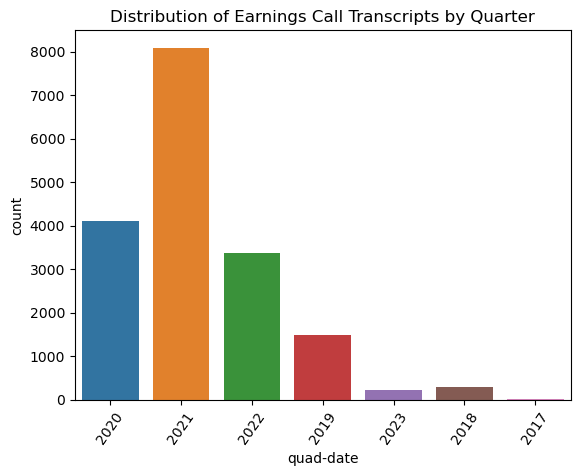

In [9]:
sns.countplot(x='quad-date', data=data)
plt.title('Distribution of Earnings Call Transcripts by Quarter')
plt.xticks(rotation=55)
plt.show()


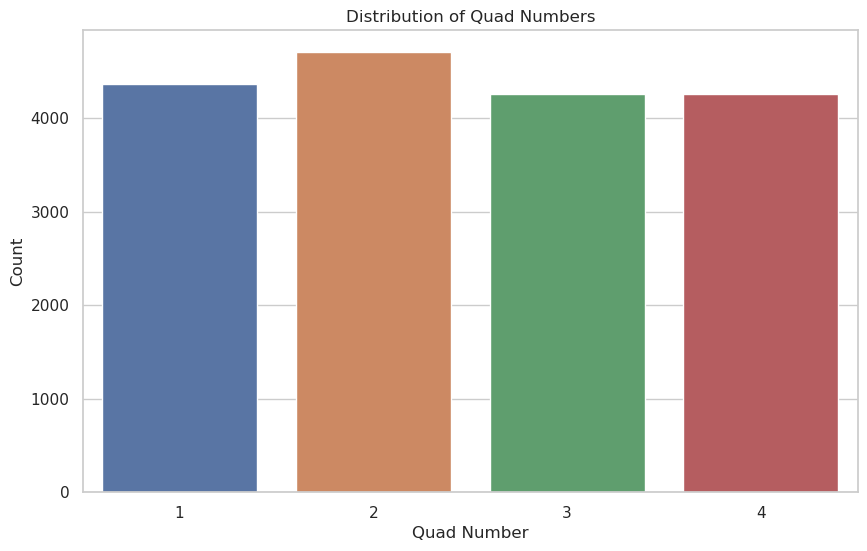

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x="quad-number", data=data)
plt.title("Distribution of Quad Numbers")
plt.xlabel("Quad Number")
plt.ylabel("Count")
plt.show()

# check length of transcripts

In [11]:
data.head()

,date,exchange,ticker,transcript,Call participants,Q&A,quad-date,quad-number
9910,"Feb 18, 2020, 4:30 p.m. ET",NYSE: A,A,good afternoon welcome agilent technologies ' ...,Ankur Dhingra -- Vice President of Investor Re...,:\nOperator\n[Operator Instructions] Your firs...,2020,1
790,"May 21, 2020, 4:30 p.m. ET",NYSE: A,A,good afternoon welcome agilent technologies ' ...,Ankur Dhingra -- Vice President of Investor Re...,:\nOperator\n[Operator Instructions] And our f...,2020,2
10319,"Aug 18, 2020, 4:30 p.m. ET",NYSE: A,A,good afternoon welcome agilent technologies th...,Ankur Dhingra -- Vice President of Investor Re...,:\nOperator\nCertainly. [Operator Instructions...,2020,3
9879,"Nov 23, 2020, 4:30 p.m. ET",NYSE: A,A,"good afternoon , welcome agilent technologies ...",Ankur Dhingra -- Vice President of Investor Re...,:\nOperator\nCertainly. [Operator Instructions...,2020,4
10252,"Feb 16, 2021, 4:30 p.m. ET",NYSE: A,A,good afternoon welcome agilent technologies fi...,Ankur Dhingra -- Vice President of Investor Re...,:\nAnkur Dhingra -- Vice President of Investor...,2021,1


In [12]:
data["transcripts-len"]=data["transcript"].apply(len)
data["Call participants-len"]=data["Call participants"].apply(len)
data["Q&A-len"]=data["Q&A"].apply(len)

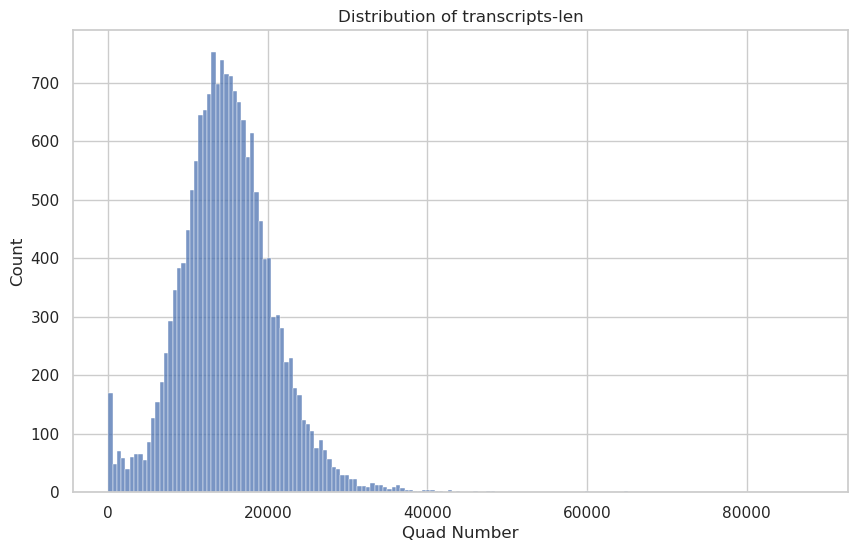

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(x="transcripts-len", data=data)
plt.title("Distribution of transcripts-len")
plt.xlabel("Quad Number")
plt.ylabel("Count")
plt.show()

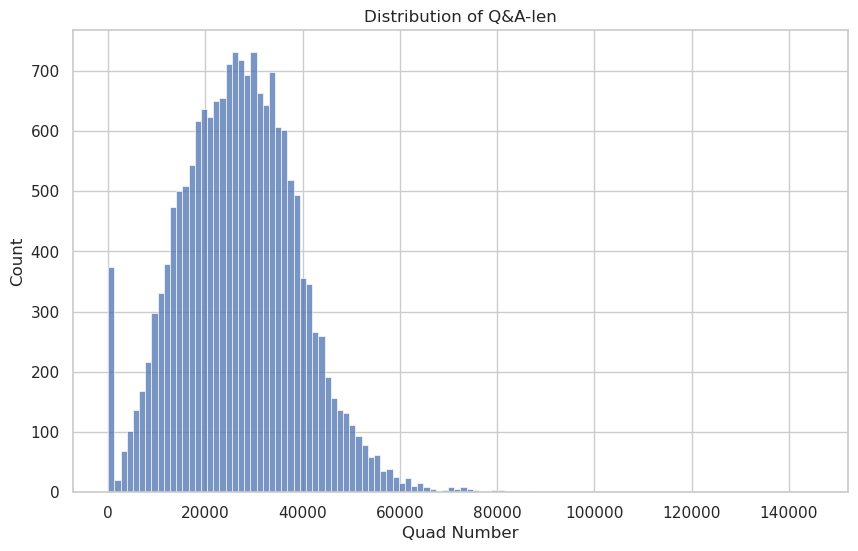

In [14]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(x="Q&A-len", data=data)
plt.title("Distribution of Q&A-len")
plt.xlabel("Quad Number")
plt.ylabel("Count")
plt.show()

In [22]:
from huggingface_hub import notebook_login

notebook_login()